In [218]:
library(igraph)

create.node.file <- function(path, city) {
    #As the file city-start-times-final already got name, latitude, longitude and year
    #We just have to add the nodeID
    node.data <- read.table(path, header = FALSE, stringsAsFactors = FALSE, fill= TRUE)


    # Check if the file has more than 4 columns
    if (ncol(node.data) > 4) {
        # If more than 4 columns, select only the first 4 columns
        node.data <- node.data[, 1:4]
    }
    if (ncol(node.data) < 4) {
        return()
    }

    node.data <- na.omit(node.data)
    
    colnames(node.data) <- c("nodeLabel", "latitude", "longitude", "year")
    node.data$nodeID <- seq_len(nrow(node.data))

    node.data <- node.data[ ,c("nodeID", "nodeLabel", "latitude", "longitude", "year")]

    ouptut.file.name <- paste0("Node", city, ".txt")

    write.table(node.data, file = ouptut.file.name, row.names = FALSE, sep = "\t")
}

#Selectiomn of the paths
cities.nodes.path <- list.files(path = "./data", pattern = "(positions-years|stations-times|stations-times-final).txt", 
                               recursive = TRUE, full.names = TRUE)
cities.nodes.path <- grep("Zone.Identifier|old|OLD|archive", cities.nodes.path, value = TRUE, invert = TRUE)

print(cities.nodes.path)
for (file in cities.nodes.path) {
    city.name <- gsub("^./data/([^/]+)/.*$", "\\1", file)
    create.node.file(file, city.name)
}
    


#create.node.file("./data/Moscow/moscow-stations-times-final.txt", "Moscow")
    



    

[1] "./data/Moscow/moscow-stations-times-final.txt"        
[2] "./data/New_tokyo/tokyo-stations-positions-years.txt"  
[3] "./data/NewNYC/nyc-stations-times.txt"                 
[4] "./data/NYC/nyc-stations-times.txt"                    
[5] "./data/Osaka/osaka-stations-positions-years.txt"      
[6] "./data/Paris/paris-stations-positions-years.txt"      
[7] "./data/Seoul/seoul-stations-times.txt"                
[8] "./data/Shanghai/shanghai-stations-positions-years.txt"


In [269]:
library(dplyr)
library(stringr)

# Function to create a lookup table from the node file for a specific city
lookup.table <- function(node.file.path) {
  node.data <- read.table(node.file.path, header = TRUE, sep = "\t", 
                          stringsAsFactors = FALSE)
  lookup_table <- node.data %>%
    select(nodeLabel, nodeID)  # Keep it as a data.frame
  return(lookup_table)
}

# Function to read a line file and convert node labels to node IDs
process.line.file <- function(line.path, lookup_table) {
  lines.data <- read.table(line.path, header = FALSE, stringsAsFactors = FALSE, fill = TRUE)
  colnames(lines.data) <- c("startStation", "endStation")
  
  # Perform left join with lookup table to map station names to node IDs
  lines.data <- lines.data %>%
    left_join(lookup_table, by = c("startStation" = "nodeLabel"), relationship = "many-to-many") %>%
    rename(nodeID_from = nodeID) %>%
    left_join(lookup_table, by = c("endStation" = "nodeLabel"), relationship = "many-to-many") %>%
    rename(nodeID_to = nodeID)
  
  return(lines.data)
}

# Function to read the years data from the file
get.years <- function(years.path) {
  years.data <- read.table(years.path, header = TRUE, stringsAsFactors = FALSE)
  colnames(years.data) <- c("Line", "LinePath", "Year")
  return(years.data)
}

# Function to create the edge file for a specific city
edge.file <- function(node.path, lines.path, year.path, city.name, 
                      is_NewNYC = FALSE, is_osaka = FALSE, is_seoul = FALSE) {
  years.data <- get.years(year.path)
  lookup_table <- lookup.table(node.path)
  edges.city <- data.frame()

  for (line in lines.path) {
    if (is_NewNYC){
      line_name <- gsub(".*/([^/]+)\\.txt$", "\\1", line)
    } else if (is_osaka) {
      line_name <- str_extract(line, "(?<=-)[0-9]+") %>% 
        paste0("line", .)
    } else if (is_seoul) {
        if (nchar(line) > 28) {
            line_name <- gsub(".*/seoul-line(\\w+)\\.txt$", "\\1", line, ignore.case = TRUE)
        } else {
            line_name <- gsub(".*/[a-zA-Z]+-|\\.txt$", "", line, ignore.case = TRUE)
        }    
    } else {
      line_name <- gsub(".*/[a-zA-Z]+-|\\.txt$", "", line, ignore.case = TRUE)
    }

    line_name <- tolower(line_name)
    
    # Process the line file
    line_data <- process.line.file(line, lookup_table)

    # Get the year for the line
    line_year <- years.data %>%
      mutate(Line = tolower(Line)) %>%
      filter(Line == line_name) %>%
      pull(Year)
    
    line_data <- line_data %>%
      mutate(line = line_name, year = line_year) %>%
      select(nodeID_from, nodeID_to, line, year)  # Ensure correct columns
    edges.city <- rbind(edges.city, line_data)
  }
  
  # Write the edge file for the city
  output_file_name <- paste0("Edges", city.name, ".txt")
  write.table(edges.city, file = output_file_name, row.names = FALSE, sep = "\t")
}




                                  

In [272]:
#AS THERE ARE SOME SPECIFICS FOR EACH CITY LINES I AM GOING TO PERFORM THE EDGE LIST CITY BY CITY

#MOSCOW
lines.files.moscow <- list.files(path = "./data/Moscow", pattern = "line", 
                               recursive = TRUE, full.names = TRUE)
lines.files.moscow <- grep("Zone.Identifier|old|lines|linel1", lines.files.moscow, value = TRUE, invert = TRUE)

edge.file("./Nodes/NodeMoscow.txt", lines.files.moscow, "./data/Moscow/moscow-lines.txt", "Moscow", is_NewNYC = FALSE)

#NEW TOKIO

lines.files.newtokyo <- list.files(path = "./data/New_tokyo", pattern = "ligne", 
                               recursive = TRUE, full.names = TRUE)
lines.files.newtokyo <- grep("Zone.Identifier|old|lignes|ligne14", lines.files.newtokyo, value = TRUE, invert = TRUE)
#I have checked the lignes file and ligne14 doesn't appear so I am not going to add it because I don't know its year

edge.file("./Nodes/NodeNew_tokyo.txt", lines.files.newtokyo, "./data/New_tokyo/tokyo-lignes.txt", "New_Tokyo")

#NewNYC

lines.files.newnyc <- list.files(path = "./data/NewNYC", pattern = "Line", 
                               recursive = TRUE, full.names = TRUE)
lines.files.newnyc <- grep("Zone.Identifier|lines", lines.files.newnyc, value = TRUE, invert = TRUE)

edge.file("./Nodes/NodeNewNYC.txt", lines.files.newnyc, "./data/NewNYC/nyc-lines.txt", "NewNYC", is_NewNYC = TRUE)

#NYC

lines.files.nyc <- list.files(path = "./data/NYC", pattern = "line", 
                               recursive = TRUE, full.names = TRUE)
lines.files.nyc <- grep("Zone.Identifier", lines.files.nyc, value = TRUE, invert = TRUE)

edge.file("./Nodes/NodeNYC.txt", lines.files.nyc, "./data/NYC/nyc-lignes.txt", "NYC")


#OSAKA

lines.files.osaka <- list.files(path = "./data/Osaka", pattern = "osaka-", 
                               recursive = TRUE, full.names = TRUE)
lines.files.osaka <- grep("Zone.Identifier|topologies|ceruleanblue|lines|stations", 
                          lines.files.osaka, value = TRUE, invert = TRUE)
#print(lines.files.osaka)

edge.file("./Nodes/NodeOsaka.txt", lines.files.osaka, "./data/Osaka/osaka-lines.txt", "Osaka", is_osaka = TRUE)

#PARIS

lines.files.paris <- list.files(path = "./data/Paris", pattern = "ligne", 
                               recursive = TRUE, full.names = TRUE)
lines.files.paris <- grep("Zone.Identifier|lignes|archive", lines.files.paris, value = TRUE, invert = TRUE)


edge.file("./Nodes/NodeParis.txt", lines.files.paris, "./data/Paris/paris-lignes.txt", "Paris")

#SEOUL

lines.files.seoul <- list.files(path = "./data/Seoul", pattern = "line", 
                               recursive = TRUE, full.names = TRUE)
lines.files.seoul <- grep("Zone.Identifier", lines.files.seoul, value = TRUE, invert = TRUE)

edge.file("./Nodes/NodeSeoul.txt", lines.files.seoul, "./data/Seoul/seoul-lignes.txt", "Seoul", is_seoul = TRUE)

#SHANGAI

lines.files.shanghai <- list.files(path = "./data/Shanghai", pattern = "line", 
                               recursive = TRUE, full.names = TRUE)
lines.files.shanghai <- grep("Zone.Identifier|lines|openloop", lines.files.shanghai, value = TRUE, invert = TRUE)

edge.file("./Nodes/NodeShanghai.txt", lines.files.shanghai, "./data/Shanghai/shanghai-lines.txt",
          "Shanghai")




In [295]:
cities <- c("Moscow", "New Tokyo", "New NYC", "NYC", "Osaka", "Paris", "Seoul", "Shanghai")

edges.paths <- list.files(path = "Edges/", recursive = TRUE, full.names = TRUE)

i <- 0

for (path in edges.paths) {
    i <- i + 1
    
    edges <- read.table(path, header = TRUE, sep = "\t", stringsAsFactors = FALSE)
    
    g <- graph_from_data_frame(edges, directed = FALSE)
    
    unique_lines <- unique(edges$line)
    
    color_palette <- rainbow(length(unique_lines))
    
    line_colors <- setNames(color_palette, unique_lines)
    
    E(g)$color <- line_colors[edges$line]
    
    par(cex.main = 0.7)
    
    png(filename = paste0("CityGraph_", cities[i], ".png"), width = 1600, height = 900, res = 150)
    
    plot(g, vertex.size = 0, vertex.label = NA, 
         main = paste0(cities[i], " subway graph"), edge.color = E(g)$color)
    
    dev.off()
}




Warning message in graph_from_data_frame(edges, directed = FALSE):
“In `d' `NA' elements were replaced with string "NA"”


Images saved successfully for all cities.


Warning message in graph_from_data_frame(edges, directed = FALSE):
“In `d' `NA' elements were replaced with string "NA"”


city,mean_degree,diameter,avg_path_length,clustering_coefficient,assortativity
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Moscow,2.343284,24,9.440579,0.019607843,0.4659324
New Tokyo,2.562212,32,10.398916,0.025428257,0.2533713
New NYC,4.322581,59,20.989421,0.018069933,0.3712834
NYC,3.958525,55,16.114228,0.029113948,0.3190522
Osaka,2.300000,23,8.454545,0.000000000,0.2098974
Paris,2.664452,33,11.793289,0.022404933,0.2001494
Seoul,3.141667,66,19.912804,0.008335893,0.7603137
Shanghai,2.292887,41,14.577160,0.001943199,0.1753367


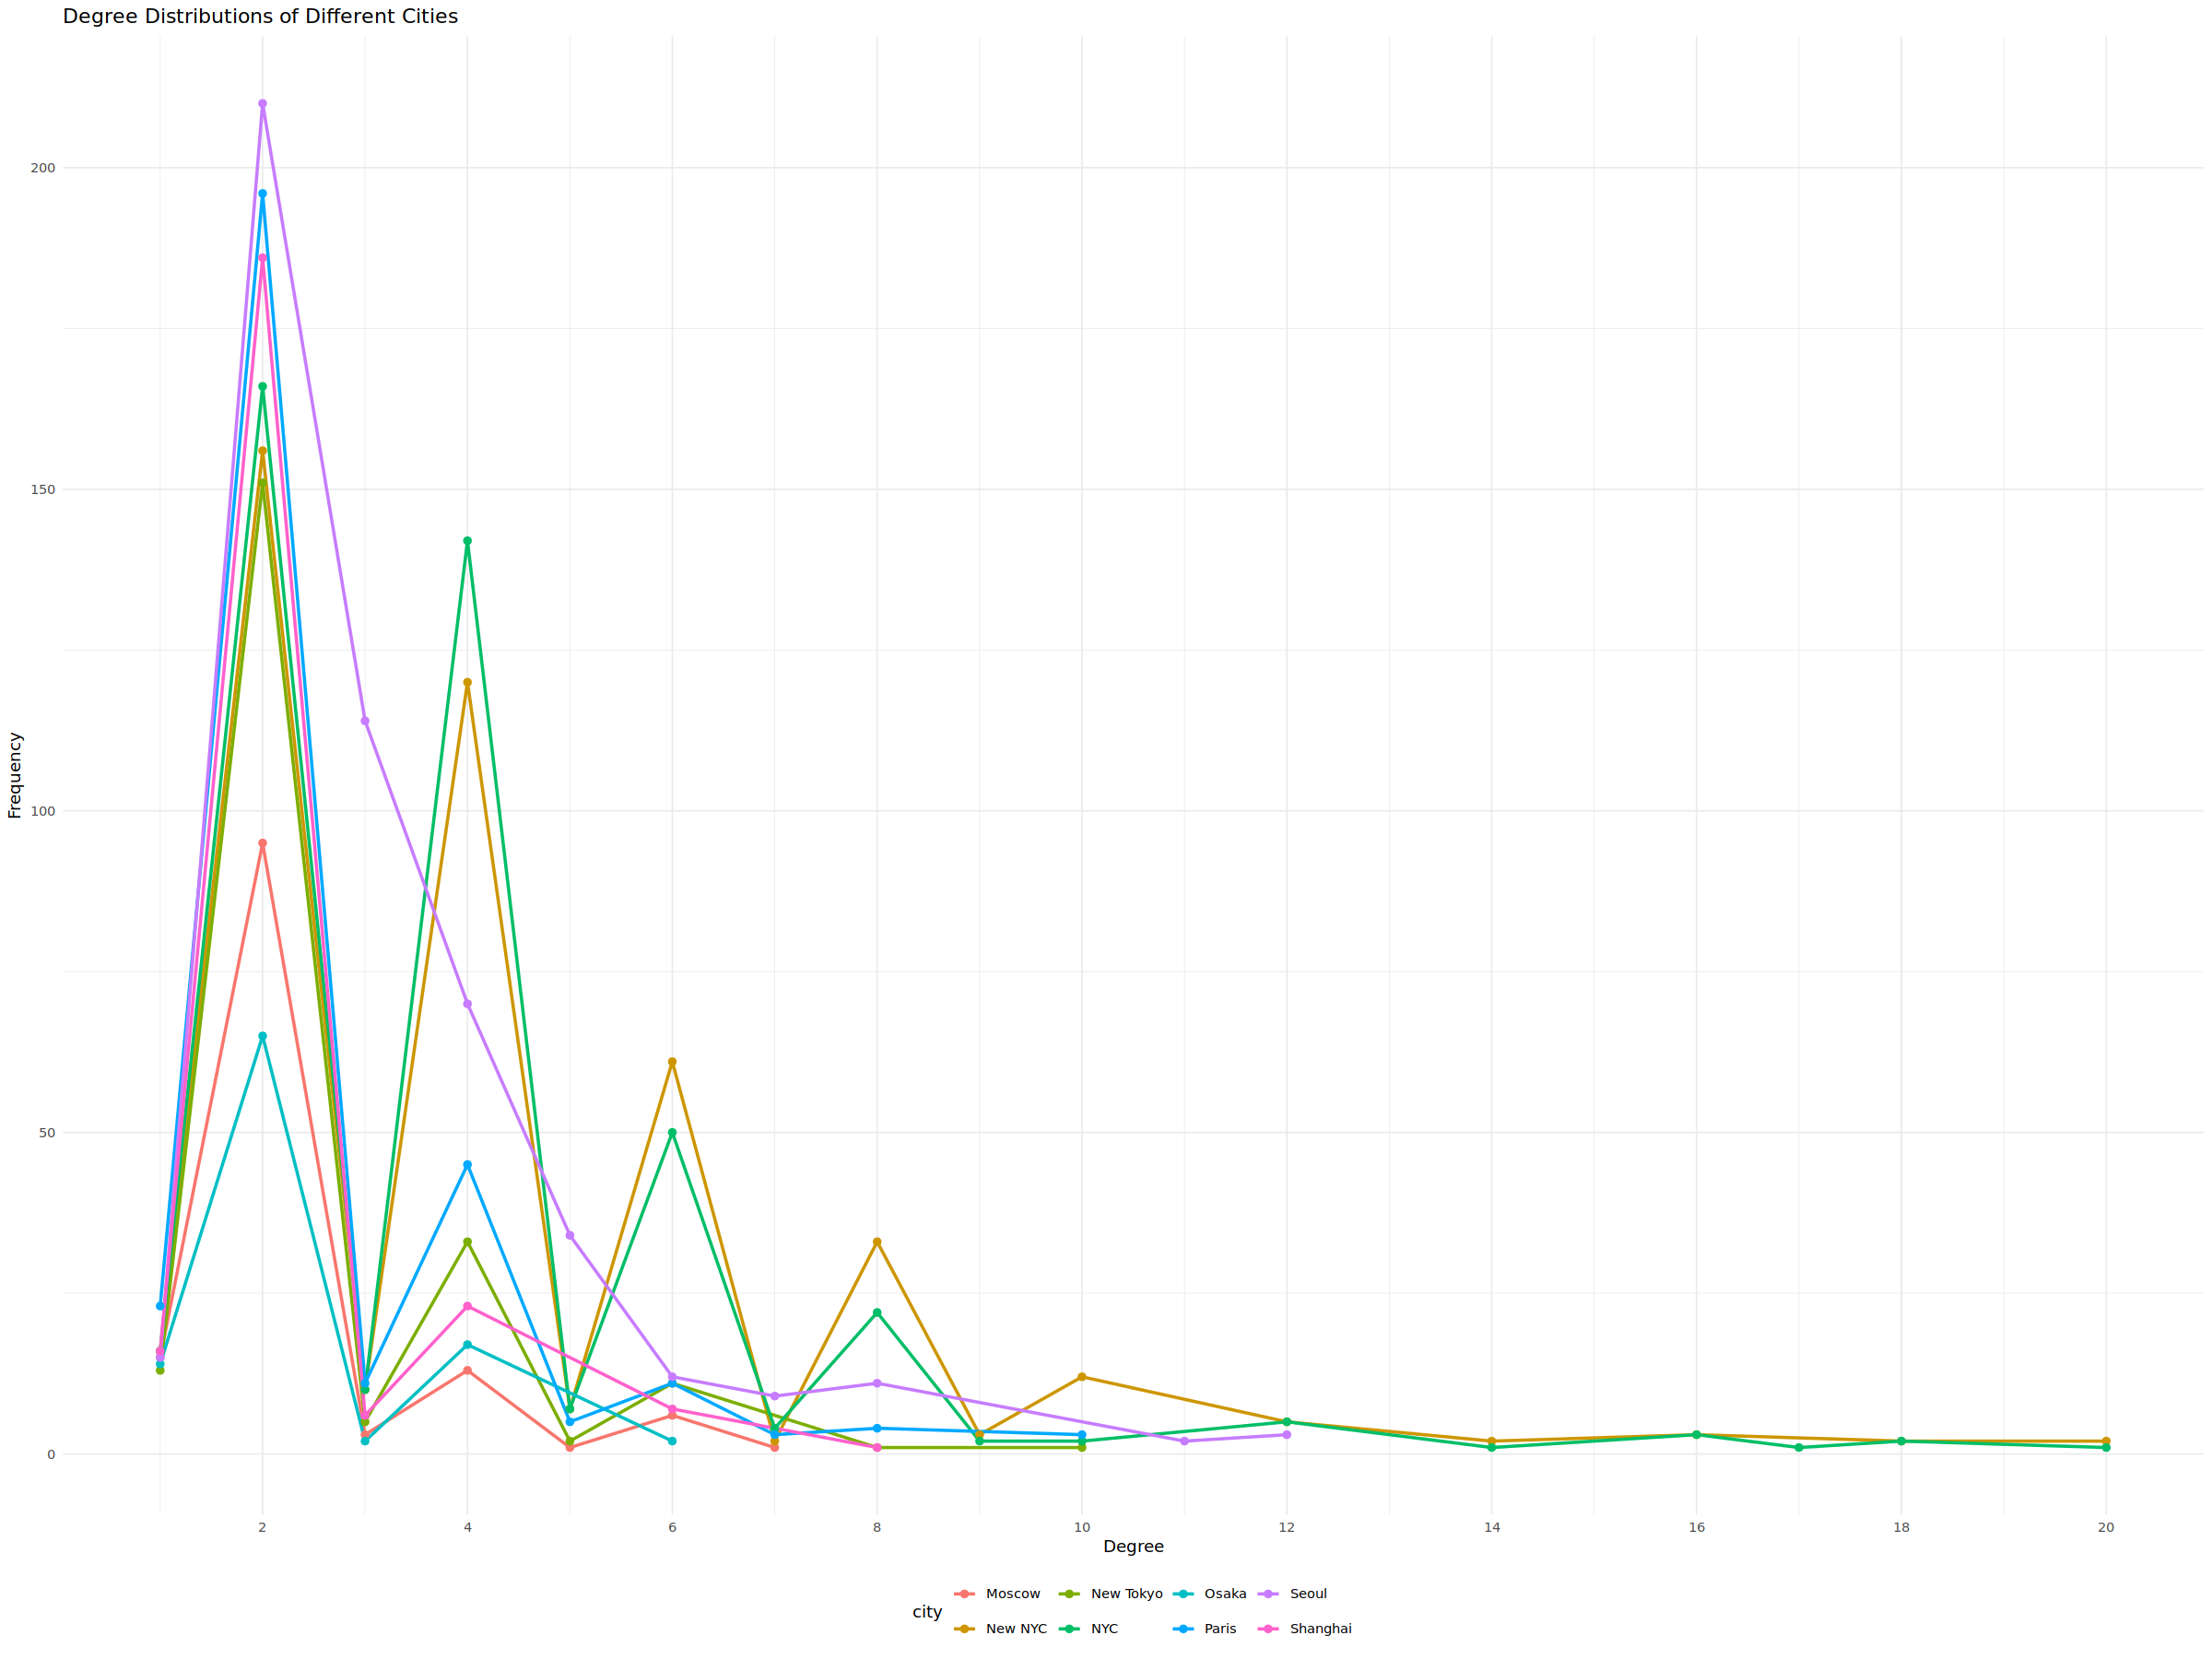

In [311]:
# Initialize an empty dataframe to store results
library(ggplot2)

results_df <- data.frame(
  city = character(),
  mean_degree = numeric(),
  diameter = numeric(),
  avg_path_length = numeric(),
  clustering_coefficient = numeric(),
  assortativity = numeric(),
  stringsAsFactors = FALSE
)

degree_data <- data.frame(
  city = character(),
  degree = integer(),
  frequency = integer(),
  stringsAsFactors = FALSE
)


# List all the edge files in the directory
edges.paths <- list.files(path = "Edges/", recursive = TRUE, full.names = TRUE)

i <- 0

# Loop through each file path
for (path in edges.paths) {
    # Read the edge list from the file
    edges <- read.table(path, header = TRUE, sep = "\t", stringsAsFactors = FALSE)

    i <- i+1
    
    # Create the graph from the edge list
    g <- graph_from_data_frame(edges, directed = FALSE)
    
    # Calculate various metrics for the graph
    kmean <- mean(degree(g))
    kdistr <- table(degree(g))
    #ncc <- length(components(g)$csize)
    gcc <- induced_subgraph(g, which(components(g)$membership == which.max(components(g)$csize)))
    diam <- diameter(gcc)
    av.len.path <- mean_distance(gcc)
    clust.coef <- transitivity(g, type = "average")
    ass.coef <- assortativity_degree(g)
    city_name <- cities[i] # Gets the file name from the path
    
    # Append results to the dataframe
    results_df <- rbind(results_df, data.frame(
      city = city_name,
      mean_degree = kmean,
      diameter = diam,
      avg_path_length = av.len.path,
      clustering_coefficient = clust.coef,
      assortativity = ass.coef,
      stringsAsFactors = FALSE
    ))

    degree_data <- rbind(degree_data, data.frame(
      city = rep(city_name, length(kdistr)),
      degree = as.integer(names(kdistr)),
      frequency = as.integer(kdistr)
    ))
}


ggplot(degree_data, aes(x = degree, y = frequency, color = city)) +
  geom_line(size = 1) + # Line plot to connect the points
  geom_point(size = 2) + # Points for each degree
  #scale_y_log10() + # Log scale for better visualization of skewed distributions
  scale_x_continuous(breaks = scales::pretty_breaks(n = 10)) + # Adjust x-axis for better readability
  labs(title = "Degree Distributions of Different Cities",
       x = "Degree",
       y = "Frequency") +
  theme_minimal() +
  theme(legend.position = "bottom") # Move legend to the bottom
# Print the results dataframe

results_df
    